/home/tom/anaconda3/envs/mantid/lib/python3.6/site-packages/ipykernel_launcher.py:43: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


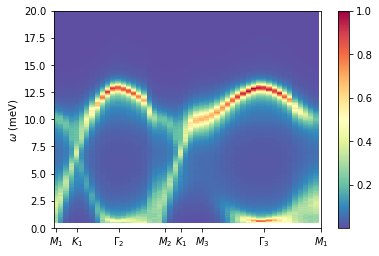

In [6]:
import os
import h5py 
import numpy as np 
from numpy import array as npa 
from matplotlib import pyplot as pl 
import pandas as pd
from itertools import product
import matplotlib as mpl
import copy
from matplotlib.patches import RegularPolygon
from scipy.interpolate import interp2d, griddata
from matplotlib.tri import Triangulation, CubicTriInterpolator, LinearTriInterpolator, TriInterpolator
import string


# Neutron scattering structure factor definitions
def structure_factor(spins, qs, basis=np.eye(3)):
#     diag = spins[...,(0, 4, 8)].sum(axis=-1)
    cond = (qs[:,0] == 0) & (qs[:,1] == 0) & (qs[:,2] == 0)
    qs[cond] = np.ones(3) * 1e-8
    qsquared = qs[:, 0]**2+qs[:, 1]**2+qs[:, 2]**2
    SF= np.zeros(spins.shape[:-1])

    for a in range(3):
        for b in range(3):
            projector = np.dot(basis[:,a], basis[:,b]) - (
                np.einsum("ij,j",qs, basis[:,a]) * np.einsum("ij,j",qs, basis[:,b])) / qsquared
            SF += projector * spins[...,a+b+(2*a)] 
            
    return SF

def get_formatted(keys):
    for i, k in enumerate(keys):
        key = list(k)
        if key[0] == "G":
            keys[i] = r"$\Gamma_{}$".format(key[1])
        else: 
            keys[i] = r"${}_{}$".format(key[0], key[1])
    return keys


# read data from hdf5 file
f = h5py.File("configuration_0.h5")
Suv = npa(f["spin_correlations/S_qw"])
freq = npa(f["spin_correlations/freq"])
ks = npa(f["spin_correlations/momentum"])
pc = npa(f["spin_correlations/pc"])
T = f.attrs["T"]
J1x = f.attrs["J1x"]
J1z = f.attrs["J1z"]
J3x = f.attrs["J3x"]
J3z = f.attrs["J3z"]
D = f.attrs["D"]
E = f.attrs["E"]
betaomega = 1/T * freq
f.close()

# mask singularities
omit=[12, 19, 20, 22, 44, 51]

shift = 1
for i, p in enumerate(omit):
    cond = p < pc 
    pc[cond] -= shift 

DSF = structure_factor(Suv, np.c_[ks, np.zeros(ks.shape[0])])
x = ks[:,0]/(2*np.pi)
xs = ks[~np.isin(np.arange(ks.shape[0]),omit),0] / (2*np.pi)
DSF = DSF[:,~np.isin(np.arange(ks.shape[0]),omit)]

# splice data
d = (DSF.T*betaomega).T 
d = d[freq>0.5, :]
xs = np.arange(xs.shape[0])


# plot 
fig, ax = pl.subplots() 
c = "Spectral_r"
cmap = copy.copy(mpl.cm.get_cmap(c))
c1 = ax.pcolormesh(xs, freq[freq>0.5], (d/d.max()), cmap=cmap, shading="auto")

ax.set_ylabel(r"$\omega$ (meV)")

ax.set_ylim([0, 20])
labels = get_formatted(["M1", "K1", "G2", "M2", "K1", "M3", "G3", "M1"])
ax.set_xticks(pc)
# labels = xs
# ax.set_xticks(xs)
ax.set_xticklabels(labels)

fig.colorbar(c1, ax=ax, use_gridspec=True)
#fig.savefig("DSSF.png")
pl.savefig('md_1K.png',dpi=300)
pl.show()


In [4]:
pc

array([ 0.,  4., 12., 21., 24., 28., 40., 51.])

In [7]:
len(xs)

51